# Защита персональных данных клиентов

Нужно защитить данные клиентов страховой компании «Хоть потоп», разработав такой метод преобразования данных, чтобы а) по ним было сложно восстановить персональную информацию и б) при преобразовании качество модели линейной регрессии не ухудшалось. Корректность работы метода необходимо обосновать.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обоснование-алгоритма-преобразования" data-toc-modified-id="Обоснование-алгоритма-преобразования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обоснование алгоритма преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Загрузка данных

Подключим необходимые библиотеки и выставим полезные умолчания.

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot

Загрузим датасет и взглянем на него.

In [23]:
path = r'C:\users\Victor\Projects\8. Линейная алгебра\insurance.csv'
if not os.path.exists(path):
    path = '/datasets/insurance.csv'
    if not os.path.exists(path): 
        path = 'https://code.s3.yandex.net' + path
print(path)
try:
    df = pd.read_csv(path)
except HTTPError as err:
    print(f'{err} {path}')

C:\users\Victor\Projects\8. Линейная алгебра\insurance.csv


In [24]:
df

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


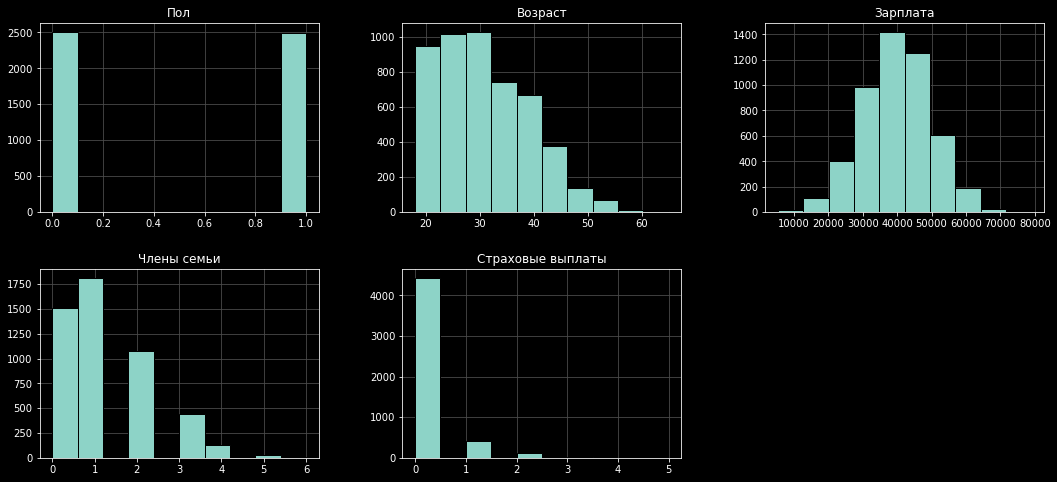

In [26]:
df.hist(edgecolor='k', layout=(2, 3), figsize=(18, 8));

Пропусков нет. Распределение значений в столбцах адекватное. Переименуем столбцы.

In [27]:
df.columns = ['gender', 'age', 'salary', 'n_family_members', 'n_insurance_payouts']

Проверим датасет на наличие полных дублей.

In [28]:
df[df.duplicated()]

,gender,age,salary,n_family_members,n_insurance_payouts
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
...,...,...,...,...,...
4793,1,24.0,37800.0,0,0
4902,1,35.0,38700.0,1,0
4935,1,19.0,32700.0,0,0
4945,1,21.0,45800.0,0,0


153 полных дубля. Здесь их наличие допустимо, потому что в датасете нет столбца с id клиента, а совпадение клиентов по представленному набору признаков вполне вероятно.

Приведем столбцы к более экономичным типам данных.

In [8]:
df = df.round().astype(int).apply(pd.to_numeric, downcast='unsigned')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              5000 non-null   uint8 
 1   age                 5000 non-null   uint8 
 2   salary              5000 non-null   uint32
 3   n_family_members    5000 non-null   uint8 
 4   n_insurace_payouts  5000 non-null   uint8 
dtypes: uint32(1), uint8(4)
memory usage: 39.2 KB


## Обоснование алгоритма преобразования

Далее будем использовать следующие обозначения:
- $n$ – число объектов (строк) в датасете
- $m$ – число признаков в датасете
- $y$ – вектор целевого признака длины $n$
- $X$ – матрица признаков размера $n \times m$
- $X_1$ – расширенная матрица признаков (нулевой столбец состоит из единиц) размера $n \times (m+1)$
- $P$ – обратимая шифрующая матрица размера $m \times m$
- $P_1$ – обратимая матрица размера $(m+1) \times (m+1)$
- $w$ – вектор весов линейной регрессии длины $m+1$ (нулевой элемент равен сдвигу)
- $a$ – вектор предсказаний линейной регрессии длины $n$
- $\tilde{X}$, $\tilde{X_1}$, $\tilde{w}$, $\tilde{a}$ – матрицы и векторы после преобразования

В качестве алгоритма преобразования исследуем умножение матрицы признаков справа на обратимую шифрующую матрицу $P$ размера $m \times m$. 

Сначала докажем, что умножение расширенной матрицы признаков $X_1$ справа на *любую* обратимую матрицу $P_1$ в формуле вектора весов линейной регрессии *не меняет* предсказания последней. Подставим выражение для преобразованной расширенной матрицы признаков $\tilde{X_1} = X_1 P_1$ в формулу вектора весов: 

$$
\tilde{w} = \left(\tilde{X_1}^T \tilde{X_1}\right)^{-1} \tilde{X_1}^T y = \newline
= \left[\left(X_1P_1\right)^T X_1P_1\right]^{-1} \left(X_1P_1\right)^T y = \newline
= \left(P_1^T X_1^T X_1P_1\right)^{-1} P_1^T X_1^T y = \newline
= P_1^{-1} \left(X_1^T X_1\right)^{-1} \left(P_1^T\right)^{-1} P_1^T X_1^T y =\newline
= P_1^{-1} \left(X_1^T X_1\right)^{-1} X_1^T y = \newline
= P_1^{-1} w
$$

Новые веса получаются из старых умножением слева на матрицу, обратную $P_1$. Подставим этот результат в формулу предсказаний линейной регрессии, сделанных на преобразованной той же матрицей $P_1$ признаках:

$$
\tilde{a} = \tilde{X_1} \tilde{w} = X_1 P_1 P_1^{-1} w = X_1 w = a
$$

Предсказания не отличаются от сделанных на *исходной* расширенной матрице признаков. По последней выкладке также видно, что то же самое будет верно и для любого другого (не обучающего) набора признаков.

Теперь докажем, что для любой обратимой матрицы $P$ размера $m \times m$ существует такая обратимая матрица ${P_1}$ размера $(m+1) \times (m+1)$, что умножение матрицы признаков $X$ справа на $P$ и последующее добавление к результату нулевого столбца из единиц (расширение) эквивалентно умножению расширенной (с нулевым столбцом из единиц) матрицы признаков $X_1$ справа на $P_1$. Рассмотрим матрицу ${P_1}$ следующего вида:

$$
{P_1} = \begin{pmatrix}
         1 & \begin{matrix} 0 & \cdots & 0 \end{matrix} \\
         \begin{matrix} 0 \\ \vdots \\ 0 \end{matrix} & {\huge P}
      \end{pmatrix}
$$

${P_1}$ – это матрица $P$, расширенная сверху на одну строку и слева на один столбец. В нулевой строке расширенной матрицы первый елемент равен единице, остальные – нулю; аналогично и в нулевом столбце.

Легко показать, что если матрица $P$ обратима, то обратима и матрица ${P_1}$. Действительно, обратимость матрицы [эквивалентна](https://ru.wikipedia.org/wiki/Обратная_матрица) неравенству нулю ее определителя. Если разложить определитель матрицы ${P_1}$ на [миноры](https://ru.wikipedia.org/wiki/Минор_(линейная_алгебра)) по нулевой строке, то все слагаемые, кроме первого, будут равны нулю, а значит определитель матрицы ${P_1}$ равен определителю матрицы $P$:

$$
\det{P_1} = \det P
$$

Поэтому если матрица $P$ обратима, то обратима и матрица ${P_1}$. 

Далее покажем, что умножение расширенной матрицы признаков справа на ${P_1}$ дает расширенную версию (нулевой столбец состоит из единиц) *преобразованной* матрицы признаков:

$$
X_1 {P_1} = 
\begin{pmatrix}
    \begin{matrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{matrix} 
    & {\huge X}
\end{pmatrix}
\begin{pmatrix}
    1 & \begin{matrix} 0 & \cdots & 0 \end{matrix} \\
    \begin{matrix} 0 \\ \vdots \\ 0 \end{matrix} & {\huge P}
\end{pmatrix} =
\begin{pmatrix}
    \begin{matrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{matrix} 
    & {\huge XP}
\end{pmatrix} =
\begin{pmatrix}
    \begin{matrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{matrix} 
    & {\huge \tilde{X}}
\end{pmatrix}
$$

То есть умножение расширенной матрицы признаков $X_1$ справа на ${P_1}$ эквивалентно умножению матрицы признаков $X$ справа на $P$ и последующее добавление к результату нулевого столбца из единиц (расширение).

Таким образом, мы доказали, что:
1) умножение расширенной матрицы признаков справа на любую обратимую матрицу в формуле вектора весов линейной регрессии не меняет предсказания линейной регрессии;
2) умножение матрицы признаков $X$ справа на обратимую матрицу $P$ с последующим расширением эквивалентно умножению расширенной матрицы признаков $X_1$ справа на обратимую матрицу ${P_1}$.

Значит алгоритм, заключающийся в умножении матрицы признаков справа на обратимую матрицу, подходит для шифрования признаков в модели линейной регрессии, потому что не меняет предсказания последней.

## Проверка алгоритма

Напишем класс модели линейной регрессии.

In [29]:
class LinearRegression:
    def __init__(self):
        pass
    def fit(self, X, y):
        self._X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self._w = np.linalg.inv(self._X.T @ self._X) @ self._X.T @ y
        return self
    def predict(self, X):
        return self._w[0] + X @ self._w[1:]  

Отделим целевой признак от остальных и разделим результат на обучающую и тестовую выборки.

In [30]:
target = 'n_insurance_payouts'
X = df.drop(columns=target).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [31]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3750, 4) (1250, 4)
(3750,) (1250,)


Сгенерируем случайную обратимую матрицу $P$ нужного размера.

In [20]:
while True:
    P = np.random.rand(X.shape[1], X.shape[1])
    if np.linalg.det(P) != 0: break
np.linalg.det(P)

0.3738455151423487

Обучим на обучающей выборке две модели: без шифрования признаков и с ним – и сравним коэффициент детерминации $R^2$ моделей на тестовой выборке.

In [32]:
clear_model = LinearRegression().fit(X_train, y_train)
encrypted_model = LinearRegression().fit(X_train @ P, y_train)

clear_score = r2_score(y_test, clear_model.predict(X_test))
encrypted_score = r2_score(y_test, encrypted_model.predict(X_test @ P))

print(f'R2 score on clear features:\t{clear_score}')
print(f'R2 score on encrypted features:\t{encrypted_score}')
print(f'R2 score difference:\t\t{encrypted_score - clear_score}')

R2 score on clear features:	0.3939441029921764
R2 score on encrypted features:	0.3939441006301392
R2 score difference:		-2.362037232472858e-09


$R^2$ моделей практически индентичен – алгоритм шифрования прошел проверку на практике.